# GAN
In this notebook, we are going to be focusing on the conditional generative adversarial network trainer in the gan module of PAI-Utils.

## Setup
To start, we will need to import packages and get the Fashion-MNIST dataset.

### Import Packages

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display

from paiutils import image
from paiutils import neural_network as nn
from paiutils import gan

# see if using GPU and if so enable memory growth
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Get Fashion-MNIST Dataset
1. Download the dataset
2. Partition data into train and validation data
3. Preprocess data for cGAN
4. Batch the datasets and create a dictionary of the data

In [2]:
# Get dataset
fashion_mnist = tfds.image_classification.FashionMNIST()
fashion_mnist.download_and_prepare()
num_classes = fashion_mnist.info.features['label'].num_classes
print(fashion_mnist.info.features)
print(fashion_mnist.info.splits)
data = fashion_mnist.as_dataset()

# Split data
val_data = data['test']
train_data = data['train']

# Preprocess train dataset
def train_preprocess(x):
    img = x['image']
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5
    img = tf.expand_dims(img, axis=-1)
    return x['label'], img
train_data = train_data.map(train_preprocess)

# Preprocess validation dataset
def val_preprocess(x):
    img = x['image']
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5
    img = tf.expand_dims(img, axis=-1)
    return (x['label'], img), tf.ones(1)
val_data = val_data.map(val_preprocess)

batch_size = 32
data = {'train': train_data.repeat().batch(batch_size),
        'validation': val_data.batch(batch_size)}
shape = train_data.element_spec[0].shape

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
{'test': <tfds.core.SplitInfo num_examples=10000>, 'train': <tfds.core.SplitInfo num_examples=60000>}


## Create the Model
We will need to make a generative network that will create images and a discriminator network that will be able to determine if an image is real or fake.

In [13]:
noise_size = 100
x0_cond = keras.layers.Input(shape=(1,), name='condition')
x_cond = keras.layers.Embedding(num_classes, 100)(x0_cond)
x_cond = nn.dense(7 * 7 * 32)(x_cond)
x_cond = keras.layers.Reshape((7, 7, 32))(x_cond)
x0 = keras.layers.Input(shape=(noise_size,), name='noise')
x = nn.dense(7*7*224)(x0)
x = keras.layers.Reshape((7, 7, 224))(x)
x = keras.layers.Concatenate()([x_cond, x])
x = nn.conv2d(128, 3, 2, transpose=True)(x)
x = nn.conv2d(64, 3, 2, transpose=True)(x)
output = nn.conv2d(1, 1, 1, activation='tanh',
                   batch_norm=False)(x)
gen_model = keras.Model(inputs=[x0_cond, x0], outputs=output)
gen_model.compile(optimizer=keras.optimizers.Adam(.0004, beta_1=.5),
                  loss='mse')
gen_model.summary()

x0_cond = keras.layers.Input(shape=(1,), name='condition')
x_cond = keras.layers.Embedding(num_classes, 100)(x0_cond)
x_cond = nn.dense(784)(x_cond)
x_cond = keras.layers.Reshape((28, 28, 1))(x_cond)
x0 = keras.layers.Input(shape=(28, 28, 1), name='y')
x = keras.layers.Concatenate()([x_cond, x0])
x = nn.conv2d(32, 3, 2, activation=None,
              batch_norm=False)(x)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.Dropout(.4)(x)
x = nn.conv2d(64, 3, 2, activation=None)(x)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.Dropout(.4)(x)
x = nn.conv2d(128, 3, 2, activation=None)(x)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.Dropout(.4)(x)
x = nn.conv2d(256, 3, 2, activation=None)(x)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.Dropout(.4)(x)
x = keras.layers.Flatten()(x)
# The GAN Trainer will apply a sigmoid to this output
output = nn.dense(1, activation=None, batch_norm=False)(x)
dis_model = keras.Model(inputs=[x0_cond, x0], outputs=output)
dis_model.compile(optimizer=keras.optimizers.Adam(.0002, beta_1=.5),
                  loss='binary_crossentropy')
dis_model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
condition (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 100)       1000        condition[0][0]                  
__________________________________________________________________________________________________
noise (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 1, 1568)      156800      embedding_6[0][0]                
______________________________________________________________________________________

## Train the Model
We can now use the GANTrainer to train the generative and discriminative models on the dataset.

In [14]:
steps_per_epoch = int(len(train_data) // batch_size)
trainer = gan.GANTrainer(
    gen_model, dis_model, data,
    conditional=True,
    idt_loss_coef=5
)
trainer.train(50, steps_per_epoch=steps_per_epoch)
path = trainer.save('')

Epoch 1/50
1875/1875 [==============================] - 17s 9ms/step - gen_loss: 2.5984 - adversarial_loss: 0.9198 - identity_loss: 0.3357 - discriminator_loss: 1.3250 - dis_fake_input_loss: 0.6559 - dis_real_input_loss: 0.6690 - val_loss: 0.4860
Epoch 2/50
1875/1875 [==============================] - 17s 9ms/step - gen_loss: 2.9909 - adversarial_loss: 1.0933 - identity_loss: 0.3795 - discriminator_loss: 1.1147 - dis_fake_input_loss: 0.5506 - dis_real_input_loss: 0.5641 - val_loss: 0.7857
Epoch 3/50
1875/1875 [==============================] - 17s 9ms/step - gen_loss: 3.6700 - adversarial_loss: 1.6000 - identity_loss: 0.4140 - discriminator_loss: 0.8398 - dis_fake_input_loss: 0.4101 - dis_real_input_loss: 0.4297 - val_loss: 0.2308
Epoch 4/50
1875/1875 [==============================] - 17s 9ms/step - gen_loss: 4.4465 - adversarial_loss: 2.3167 - identity_loss: 0.4260 - discriminator_loss: 0.5825 - dis_fake_input_loss: 0.2857 - dis_real_input_loss: 0.2968 - val_loss: 0.1119
Epoch 5/50
1

## Evaluate the Discriminator
Before testing the generator, we can evaluate the discriminator by getting losses for the validation data.

In [15]:
print(trainer.eval(batch_size=100, train_data=False))

Validation Data Evaluation: 
100/100 [==============================] - 0s 1ms/step - loss: 0.1073
{'Validation': 0.10726740956306458}


## Test the Generator
The model is now trained and saved, so we can test the generative model by using the GANPredictor to create a grid of generated images.

#### Load Generator

In [16]:
# path = 'trained_model2'
generator = gan.GANPredictor(path)

#### Display Grid of Generated Images

We will now create and display a grid of generated images.

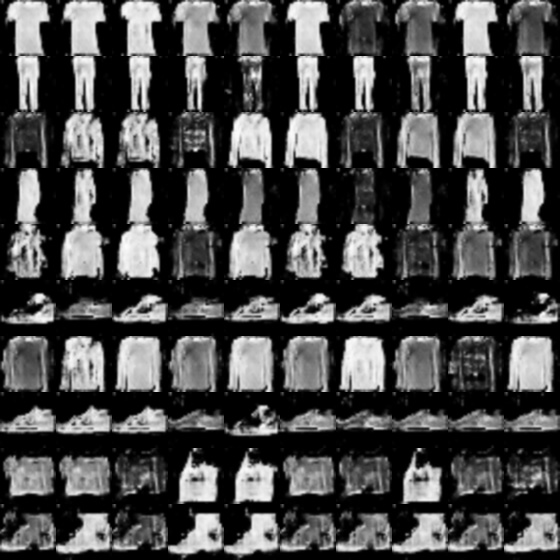

In [17]:
scale = int(2)
num_rows = 10

for _ in range(1):
    conds = np.tile(np.arange(num_classes), num_rows)
    imgs = generator.generate(n=num_classes * num_rows,
                              conditions=conds)
    imgs = [image.pyr(image.denormalize(img), scale - 1)
            for img in imgs]
    grid = np.array(imgs).reshape((num_rows, num_classes, *imgs[0].shape),
                                  order='F')
    grid = np.hstack(np.hstack(grid))
    ret = image.cv2.imencode('.jpg', grid)[1]
    display(Image(data=ret))

The generated images are not of high quality, so we could have trained for longer or used a better model. Nevertheless, we have learned how to use a conditional GAN.